In [1]:
# install packages in libs (as editable)
# !python -m pip install -e ../libs

# What this notebook is for ?
Playing around with the loss functions - giou, DETR, SSD, etc..
1. Load the filtered dataset & pick random images
2. Try out the giou to pick a box and comparing with annotated boxes (ground truth/gt) on the image.
3. Run the owl model to get the predictions 
4. try out the DETR loss
5. try out the hungarian matcher algorithm

In [2]:
# Util functions
from binsense import img_utils as iutls
from binsense import torch_utils as tults
from typing import Tuple, Union, List
from torch import Tensor

import numpy as np
import torch

## Check the giou and loss fn
1. get an image with bounding boxes
3. check the loss with a bounding box at different positions

sampleimg_name = 107792.jpg
3 --> [[  1.5625099 142.64163   260.9082    605.3369   ]
 [ 94.7412    144.01562   374.98535   603.4033   ]
 [362.8086    155.24998   655.5029    601.0205   ]]


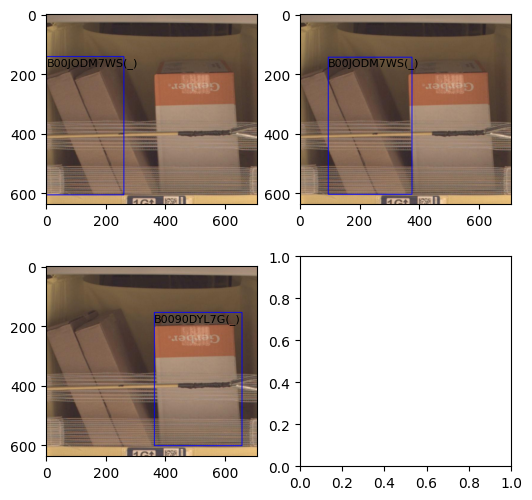

In [3]:
from binsense.dataset_util import Yolov8Deserializer, DataTag
from binsense.dataprep.config import DataPrepConfig
from binsense import img_utils as iutls
from binsense import plot_utils as putls

from typing import Dict, Any

import numpy as np
import pandas as pd
import random, PIL

cfg = DataPrepConfig()
ds = Yolov8Deserializer(cfg.filtered_dataset_path, img_extns=['.jpg']).read()
gt_df = pd.DataFrame(columns=['image_name', 'bbox_label', 'bbox_count', 'tag'])

def load_gt_df(tag: DataTag):
    imgs_data = ds.get_images(tag)
    for img_data in imgs_data:
        bboxes_data = ds.get_bboxes(img_data.name)
        bbox_counts = {}
        for bbox_data in bboxes_data:
            if bbox_data.label in bbox_counts:
                bbox_counts[bbox_data.label] += 1
            else:
                bbox_counts[bbox_data.label] = 1
        for bbox_label in bbox_counts:
            gt_df.loc[len(gt_df)] = [img_data.name, bbox_label, bbox_counts[bbox_label], tag.value]

load_gt_df(DataTag.TRAIN)
load_gt_df(DataTag.TEST)

def sample(tag: DataTag = DataTag.TRAIN, img_name: str = None) -> Dict[str, Any]:
    train_imgs = ds.get_images(DataTag.TRAIN)
    sampleimg_name = random.choice(train_imgs).name
    if img_name is not None:
        sampleimg_name = img_name
        
    sampleimg_data = ds._get_image(sampleimg_name)
    sampleimg_bboxes = ds.get_bboxes(sampleimg_data.name)
    sampleimg_labels = np.array([bbox.label for bbox in sampleimg_bboxes])
    sampleimg_pil = PIL.Image.open(sampleimg_data.path)
    sampleimg_data.width = sampleimg_pil.width
    sampleimg_data.height = sampleimg_pil.height
    
    sampleimg_cxy_bboxes = np.array([bbox.to_array() for bbox in sampleimg_bboxes])
    sampleimg_xy_bboxes = iutls.convert_cxy_xy_and_scale(
        sampleimg_cxy_bboxes,
        (sampleimg_data.width, sampleimg_data.height)
    )
    
    return {
        "img_data": sampleimg_data,
        "labels": sampleimg_labels,
        "bboxes_cxy": sampleimg_cxy_bboxes,
        "bboxes_xy": sampleimg_xy_bboxes,
        'image': sampleimg_pil
    }

sampleimg_name = "107792.jpg"
sampleimg = sample(tag=DataTag.TRAIN, img_name=sampleimg_name)
print(f"sampleimg_name = {sampleimg['img_data'].name}")

sampleimg_pil = sampleimg['image']
gt_cxy_bboxes = sampleimg['bboxes_cxy']
gt_xy_bboxes= sampleimg['bboxes_xy']
gt_labels = sampleimg['labels']
print(gt_xy_bboxes.shape[0], "-->", gt_xy_bboxes)
putls.show_bbox_ingrid(
    cv_img=np.array(sampleimg_pil),
    box_scores=list(zip(gt_xy_bboxes, [None]*len(gt_labels), gt_labels)),
    grid=(2, 2)
)

## IOU score

tensor([[-0.0885,  0.2111, -0.1609]])


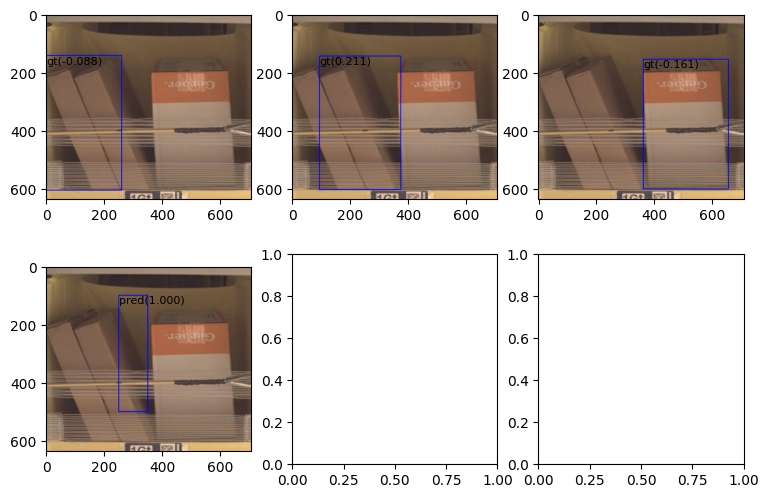

In [4]:
from binsense import img_utils as iutls
from binsense import plot_utils as putls
from torchvision.ops import generalized_box_iou, box_iou

import numpy as np
import torch

pred_xy_bbox = np.array([[250, 100, 350, 500]], dtype=np.int32)
pred_cxy_bbox = iutls.convert_xy_cxy_and_unscale(pred_xy_bbox, (sampleimg_pil.width, sampleimg_pil.height))

iou = generalized_box_iou(torch.as_tensor(pred_xy_bbox), torch.as_tensor(gt_xy_bboxes))
# iou = box_iou(torch.as_tensor(pred_xy_bbox), torch.as_tensor(gt_xy_bboxes))
print(iou)
box_scores = [(b, round(iou[0][i].item(), 3), 'gt') for i, b in enumerate(gt_xy_bboxes)]
box_scores.append((pred_xy_bbox[0], 1, 'pred'))

putls.show_bbox_ingrid(
    cv_img=np.array(sampleimg_pil),
    box_scores=box_scores,
    grid=(2, 3)
)

## Check DETR Loss

In [6]:


from binsense.owlv2.config import Owlv2Config
from binsense.owlv2.model import Owlv2ForObjectDetection
from binsense.owlv2.processor import Owlv2ImageProcessor
from binsense.owlv2 import hugg_loader as hloader
from binsense.embed_datastore import SafeTensorEmbeddingDatastore
from binsense.lightning.losses import DETRMultiBoxLoss
from binsense.lightning.config import Config as TrainConfig
import torch

device = 'mps' if torch.backends.mps.is_available() else 'cpu'

# load the model
processor = Owlv2ImageProcessor()
owl_model_cfg = Owlv2Config(**hloader.load_owlv2model_config())
model = Owlv2ForObjectDetection(owl_model_cfg)
model.load_state_dict(hloader.load_owlv2model_statedict())
for p in model.vision_model.parameters():
    p.requires_grad = False
model = model.to(device)

def run_model(x1, x2):
    x1 = x1.to(device)
    x2 = x2.to(device)
    return model(x1, x2)

# load the embedding store created by above run & check for few embeddings
embed_ds = SafeTensorEmbeddingDatastore(
    cfg.embed_store_dirpath, 
    read_only=True
).to_read_only_store()

# define loss function
tcfg = TrainConfig()
loss_fn = DETRMultiBoxLoss(
            reg_loss_coef=tcfg.reg_loss_coef, 
            giou_loss_coef=tcfg.giou_loss_coef, 
            label_loss_coef=tcfg.label_loss_coef, 
            eos_coef=tcfg.eos_coef, 
            use_focal_loss = tcfg.use_focal_loss,
            focal_loss_alpha = tcfg.focal_loss_alpha,
            focal_loss_gamma = tcfg.focal_loss_gamma,
            has_no_object_class=tcfg.use_no_object_class,
            match_cost_bbox=tcfg.match_cost_bbox,
            match_cost_giou=tcfg.match_cost_giou,
            match_cost_label=tcfg.match_cost_label
        )

## Run predictions and compute loss

In [22]:
# Prepare datasets

all_labels = list(embed_ds.get_keys())
gt_df['embedded'] = gt_df['bbox_label'].isin(all_labels)
for l in all_labels:
    if l not in gt_labels:
        not_in_query_label = l
        break
assert not_in_query_label is not None
query_label_2 = gt_labels[2]
query_label_0 = gt_labels[0]
print('bbox 2 in sample/target image', query_label_2, embed_ds.has(query_label_2))
print('bbox 0 in sample/target image', query_label_0, embed_ds.has(query_label_0))
print('not in sample/target image', not_in_query_label, embed_ds.has(not_in_query_label))

if not embed_ds.has(query_label_2) \
    or not embed_ds.has(not_in_query_label) \
    or not embed_ds.has(query_label_2):
    
    raise ValueError('the query labels are missing!! check the embed datastore.')

query_embeddings = embed_ds.get_many([query_label_0, query_label_2, not_in_query_label])
assert query_embeddings[query_label_2].shape == torch.Size([512])
assert query_embeddings[query_label_0].shape == torch.Size([512])
assert query_embeddings[not_in_query_label].shape == torch.Size([512])

bbox 2 in sample/target image B0090DYL7G True
bbox 0 in sample/target image B00JODM7WS True
not in sample/target image B00063E2FU True


### Multi Class (Single query w/o class present)
- 2 batch records, each with single query
- batch[0], query[0]: bbox 1 & 3 correspond to the label (query_label_1)
- batch[1], query[0]: none of the boxes correspond to the label (not_in_query_label)

In [23]:
from binsense import torch_utils as tutls

query_embeddings1 = torch.cat([
        query_embeddings[query_label_0].clone().reshape((1, 1, -1)), 
        query_embeddings[not_in_query_label].clone().reshape((1, 1, -1))
    ], dim=0)
single_tgt_qboxes = [
    tutls.to_float_tensor(gt_cxy_bboxes[[0, 1]]).to(device), 
    tutls.empty_tensor().to(device)
]
single_tgt_boxes = [
    tutls.to_float_tensor(gt_cxy_bboxes).to(device), 
    tutls.to_float_tensor(gt_cxy_bboxes).to(device)
]
single_tgt_labels = [
    tutls.to_int_tensor([0, 0]).to(device), 
    tutls.empty_int_tensor().to(device)
]

target_pixels = processor.preprocess(sampleimg_pil)['pixel_values']
target_pixels = target_pixels.expand(target_pixels.shape[0]+1, *target_pixels.shape[1:])
print(
    f'single-class:\n   embed shape= {query_embeddings1.shape}', 
    f'\n   target image shape = {target_pixels.shape}')
output = run_model(target_pixels, query_embeddings1)
single_pred_boxes = output[1]
single_pred_logits = output[0]
print(
    f"single-class:\n   pred_boxes:{single_pred_boxes.shape}", 
    f"\n   pred_logits:{single_pred_logits.shape}")

single_loss = loss_fn({
        "pred_boxes": single_pred_boxes, 
        "pred_logits": single_pred_logits
    }, 
    {
        "q_boxes": single_tgt_qboxes,
        "boxes": single_tgt_boxes,
        "labels": single_tgt_labels
    })
print(f"single_loss w/o  objects -> {single_loss}")

single_loss1 = loss_fn({
        "pred_boxes": single_pred_boxes[1:], 
        "pred_logits": single_pred_logits[1:]
    }, 
    {
        "q_boxes": single_tgt_qboxes[1:],
        "boxes": single_tgt_boxes[1:],
        "labels": single_tgt_labels[1:]
    })
print(f"single_loss with no-object -> {single_loss1}")

single_loss2 = loss_fn({
        "pred_boxes": single_pred_boxes[:1], 
        "pred_logits": single_pred_logits[:1]
    }, 
    {
        "q_boxes": single_tgt_qboxes[:1],
        "boxes": single_tgt_boxes[:1],
        "labels": single_tgt_labels[:1]
    })
print(f"single_loss with object -> {single_loss2}")

single-class:
   embed shape= torch.Size([2, 1, 512]) 
   target image shape = torch.Size([2, 3, 960, 960])
single-class:
   pred_boxes:torch.Size([2, 3600, 4]) 
   pred_logits:torch.Size([2, 3600, 1])
single_loss w/o  objects -> OrderedDict([('loss', tensor(0.4465, device='mps:0', grad_fn=<AddBackward0>)), ('loss_reg', tensor(0.1717, device='mps:0')), ('loss_giou', tensor(0.1948, device='mps:0')), ('loss_label', tensor(0.0800, device='mps:0'))])
single_loss with no-object -> OrderedDict([('loss', tensor(0.3768, device='mps:0', grad_fn=<AddBackward0>)), ('loss_reg', tensor(0.1717, device='mps:0')), ('loss_giou', tensor(0.1948, device='mps:0')), ('loss_label', tensor(0.0103, device='mps:0'))])
single_loss with object -> OrderedDict([('loss', tensor(0.5163, device='mps:0', grad_fn=<AddBackward0>)), ('loss_reg', tensor(0.1717, device='mps:0')), ('loss_giou', tensor(0.1948, device='mps:0')), ('loss_label', tensor(0.1498, device='mps:0'))])


### Multi Class (Dual query, both classes present)
- 1 batch record with two queries
- batch[0], query[0]: bbox 0 correspond to the label (query_label_0)
- batch[0], query[1]: bbox 1 & 3 correspond to the label (query_label_1)

In [24]:
from binsense import torch_utils as tutls

query_embeddings2 = torch.cat([
        query_embeddings[query_label_0].clone().unsqueeze(0), 
        query_embeddings[query_label_2].clone().unsqueeze(0)
    ], dim=0).unsqueeze(0)
multi_dual_tgt_qboxes = [tutls.to_float_tensor(gt_cxy_bboxes[[0, 1, 2]]).to(device)]
multi_dual_tgt_boxes = [tutls.to_float_tensor(gt_cxy_bboxes).to(device)]
multi_dual_tgt_labels = [tults.to_int_tensor([1, 1, 1]).to(device)]
target_pixels = processor.preprocess(sampleimg_pil)['pixel_values']
print(
    f'multi-class-dual-query:\n   embed shape= {query_embeddings2.shape}', 
    f'\n   target image shape = {target_pixels.shape}')
multi_output = run_model(target_pixels, query_embeddings2)

multi_dual_pred_boxes = multi_output[1]
multi_dual_pred_logits = multi_output[0]
print(
    f"multi-class-dual-query:\n   pred_boxes:{multi_dual_pred_boxes.shape}", 
    f"\n   pred_logits:{multi_dual_pred_logits.shape}")

multi_dual_loss = loss_fn({
        "pred_boxes": multi_dual_pred_boxes, 
        "pred_logits": multi_dual_pred_logits
    }, 
    {
        "q_boxes": multi_dual_tgt_qboxes,
        "boxes": multi_dual_tgt_boxes,
        "labels": multi_dual_tgt_labels
    })
print(f"multi_dual_loss1 -> {multi_dual_loss}")

multi-class-dual-query:
   embed shape= torch.Size([1, 2, 512]) 
   target image shape = torch.Size([1, 3, 960, 960])
multi-class-dual-query:
   pred_boxes:torch.Size([1, 3600, 4]) 
   pred_logits:torch.Size([1, 3600, 2])
multi_dual_loss1 -> OrderedDict([('loss', tensor(0.4524, device='mps:0', grad_fn=<AddBackward0>)), ('loss_reg', tensor(0.1717, device='mps:0')), ('loss_giou', tensor(0.1948, device='mps:0')), ('loss_label', tensor(0.0859, device='mps:0'))])


### Single Class (Single query, class not present)
- 2 batch record with single queries of same class
- class not present
- batch[0], query[0]: correspond to the label (not_in_query_label)
- batch[0], query[1]: correspond to the label (not_in_query_label)

In [25]:
from binsense import torch_utils as tutls

query_embeddings3_1 = torch.cat([
        query_embeddings[not_in_query_label].clone().reshape((1, 1, -1)), 
        query_embeddings[not_in_query_label].clone().reshape((1, 1, -1))
    ], dim=0)
single_single_no_object_tgt_qboxes = [tutls.empty_float_tensor().to(device), tutls.empty_float_tensor().to(device)]
single_single_no_object_tgt_boxes = [tutls.to_float_tensor(gt_cxy_bboxes).to(device), tutls.to_float_tensor(gt_cxy_bboxes).to(device)]
single_single_no_object_tgt_labels = [tutls.empty_int_tensor().to(device), tults.empty_int_tensor().to(device)]
target_pixels = processor.preprocess(sampleimg_pil)['pixel_values']
target_pixels = target_pixels.expand(target_pixels.shape[0]+1, *target_pixels.shape[1:])
print(
    f'single-class-single-query-no-object:\n   embed shape= {query_embeddings3_1.shape}', 
    f'\n   target image shape = {target_pixels.shape}')
multi_output = run_model(target_pixels, query_embeddings3_1)

single_single_no_object_pred_boxes = multi_output[1]
single_single_no_object_pred_logits = multi_output[0]
print(
    f"single-class-single-no-object-query:\n   pred_boxes:{single_single_no_object_pred_boxes.shape}", 
    f"\n   pred_logits:{single_single_no_object_pred_boxes.shape}")

single_single_no_object_loss = loss_fn({
        "pred_boxes": single_single_no_object_pred_boxes, 
        "pred_logits": single_single_no_object_pred_logits
    }, 
    {
        "q_boxes": single_single_no_object_tgt_qboxes,
        "boxes": single_single_no_object_tgt_boxes,
        "labels": single_single_no_object_tgt_labels
    })
print(f"single_single_no_object_loss1 -> {single_single_no_object_loss}")

single-class-single-query-no-object:
   embed shape= torch.Size([2, 1, 512]) 
   target image shape = torch.Size([2, 3, 960, 960])
single-class-single-no-object-query:
   pred_boxes:torch.Size([2, 3600, 4]) 
   pred_logits:torch.Size([2, 3600, 4])
single_single_no_object_loss1 -> OrderedDict([('loss', tensor(0.3768, device='mps:0', grad_fn=<AddBackward0>)), ('loss_reg', tensor(0.1717, device='mps:0')), ('loss_giou', tensor(0.1948, device='mps:0')), ('loss_label', tensor(0.0103, device='mps:0'))])


### Multi class (single query, both classes present)
- 2 batch records, each with single query
- batch[0], query[0]: bbox 0 correspond to the label (query_label_0)
- batch[1], query[0]: bbox 1 & 3 correspond to the label (query_label_1)

In [26]:
from binsense import torch_utils as tutls

query_embeddings3 = torch.cat([
        query_embeddings[query_label_0].clone().reshape((1, 1, -1)), 
        query_embeddings[query_label_2].clone().reshape((1, 1, -1))
    ], dim=0)
multi_single_tgt_qboxes = [tutls.to_float_tensor(gt_cxy_bboxes[[0, 1]]).to(device), tutls.to_float_tensor(gt_cxy_bboxes[[2]]).to(device)]
multi_single_tgt_boxes = [tutls.to_float_tensor(gt_cxy_bboxes).to(device), tutls.to_float_tensor(gt_cxy_bboxes).to(device)]
multi_single_tgt_labels = [tutls.to_int_tensor([0, 0]).to(device), tults.to_int_tensor([1]).to(device)]
target_pixels = processor.preprocess(sampleimg_pil)['pixel_values']
target_pixels = target_pixels.expand(target_pixels.shape[0]+1, *target_pixels.shape[1:])
print(
    f'multi-class-single-query:\n   embed shape= {query_embeddings3.shape}', 
    f'\n   target image shape = {target_pixels.shape}')
multi_output = run_model(target_pixels, query_embeddings3)

multi_single_pred_boxes = multi_output[1]
multi_single_pred_logits = multi_output[0]
print(
    f"multi-class-single-query:\n   pred_boxes:{multi_single_pred_boxes.shape}", 
    f"\n   pred_logits:{multi_single_pred_boxes.shape}")

multi_single_loss = loss_fn({
        "pred_boxes": multi_single_pred_boxes, 
        "pred_logits": multi_single_pred_logits
    }, 
    {
        "q_boxes": multi_single_tgt_qboxes,
        "boxes": multi_single_tgt_boxes,
        "labels": multi_single_tgt_labels
    })
print(f"multi_single_loss1 -> {multi_single_loss}")

multi-class-single-query:
   embed shape= torch.Size([2, 1, 512]) 
   target image shape = torch.Size([2, 3, 960, 960])
multi-class-single-query:
   pred_boxes:torch.Size([2, 3600, 4]) 
   pred_logits:torch.Size([2, 3600, 4])
multi_single_loss1 -> OrderedDict([('loss', tensor(0.4531, device='mps:0', grad_fn=<AddBackward0>)), ('loss_reg', tensor(0.1717, device='mps:0')), ('loss_giou', tensor(0.1948, device='mps:0')), ('loss_label', tensor(0.0866, device='mps:0'))])


## Loss for queries with count 0 to 5

In [27]:
from binsense import torch_utils as tutls
import pandas as pd

def compute_loss(query_label, target_image_name, loss_fn):
    target_img = sample(img_name=target_image_name)
    
    query_embeddings = embed_ds.get(query_label).clone().reshape((1, 1, -1))
    target_pixels = processor.preprocess(target_img['image'])['pixel_values']
    # print("inputs shape=", query_embeddings.shape, target_pixels.shape)
    output = run_model(target_pixels, query_embeddings)
    pred_logits = output[0]
    pred_boxes = output[1]
    
    tgt_labels = []
    tgt_qboxes = []
    tgt_boxes = []
    for i, label in enumerate(target_img['labels']):
        if label == query_label:
            tgt_labels.append(0)
            tgt_qboxes.append(target_img['bboxes_cxy'][i])
    tgt_boxes = [bbox for bbox in target_img['bboxes_cxy']]
    
    loss = loss_fn({
            "pred_boxes": pred_boxes, 
            "pred_logits": pred_logits
        },{
            "q_boxes": [tutls.to_float_tensor(tgt_qboxes).to(device)],
            "labels": [tutls.to_int_tensor(tgt_labels).to(device)],
            "boxes": [tutls.to_float_tensor(tgt_boxes).to(device)]
        })
    return loss

loss_fn_name = lambda x:f'reg={x.reg_loss_coef},giou={x.giou_loss_coef},lbl={x.label_loss_coef},a={x.focal_loss_alpha}'
loss_df = pd.DataFrame(columns=['loss_fn', 'count', 'loss', 'loss_reg', 'loss_giou', 'loss_label'])
loss_fn = DETRMultiBoxLoss(
            reg_loss_coef=tcfg.reg_loss_coef, 
            giou_loss_coef=tcfg.giou_loss_coef, 
            label_loss_coef=tcfg.label_loss_coef, 
            eos_coef=tcfg.eos_coef, 
            use_focal_loss = tcfg.use_focal_loss,
            focal_loss_alpha = tcfg.focal_loss_alpha,
            focal_loss_gamma = tcfg.focal_loss_gamma,
            has_no_object_class=tcfg.use_no_object_class,
            match_cost_bbox=tcfg.match_cost_bbox,
            match_cost_giou=tcfg.match_cost_giou,
            match_cost_label=tcfg.match_cost_label
        )
loss_fn1 = DETRMultiBoxLoss(
            reg_loss_coef=tcfg.reg_loss_coef, 
            giou_loss_coef=tcfg.giou_loss_coef, 
            label_loss_coef=tcfg.label_loss_coef, 
            eos_coef=tcfg.eos_coef, 
            use_focal_loss = tcfg.use_focal_loss,
            focal_loss_alpha = 0.05,
            focal_loss_gamma = tcfg.focal_loss_gamma,
            has_no_object_class= tcfg.use_no_object_class,
            match_cost_bbox=tcfg.match_cost_bbox,
            match_cost_giou=tcfg.match_cost_giou,
            match_cost_label=tcfg.match_cost_label
        )
query_label_count_0 = gt_df.query('embedded == True').sample(1)['bbox_label'].values[0]
target_image_count_0 = gt_df[gt_df['bbox_label'] != query_label_count_0].sample(1)['image_name'].values[0]

count_0_loss = compute_loss(query_label_count_0, target_image_count_0, loss_fn)
loss_df.loc[len(loss_df)] = [loss_fn_name(loss_fn), 0, count_0_loss['loss'].item(), 
            count_0_loss['loss_reg'].item(), count_0_loss['loss_giou'].item(), 
            count_0_loss['loss_label'].item()]
count_0_loss = compute_loss(query_label_count_0, target_image_count_0, loss_fn1)
loss_df.loc[len(loss_df)] = [loss_fn_name(loss_fn1), 0, count_0_loss['loss'].item(), 
            count_0_loss['loss_reg'].item(), count_0_loss['loss_giou'].item(), 
            count_0_loss['loss_label'].item()]

for count in range(1, 7):
    rec = gt_df[ (gt_df['embedded'] == True) & (gt_df['bbox_count'] == count) & (gt_df['tag'] == 'train') ].sample(1).iloc[0]
    loss = compute_loss(rec['bbox_label'], rec['image_name'], loss_fn)
    loss_df.loc[len(loss_df)] = [loss_fn_name(loss_fn), count, loss['loss'].item(), 
                loss['loss_reg'].item(), loss['loss_giou'].item(), 
                loss['loss_label'].item()]
    loss = compute_loss(rec['bbox_label'], rec['image_name'], loss_fn1)
    loss_df.loc[len(loss_df)] = [loss_fn_name(loss_fn1), count, loss['loss'].item(), 
                loss['loss_reg'].item(), loss['loss_giou'].item(), 
                loss['loss_label'].item()]

loss_df

,loss_fn,count,loss,loss_reg,loss_giou,loss_label
0,"reg=1,giou=1,lbl=1,a=0.3",0,0.745145,0.263143,0.474999,0.007004
1,"reg=1,giou=1,lbl=1,a=0.05",0,0.747647,0.263143,0.474999,0.009505
2,"reg=1,giou=1,lbl=1,a=0.3",1,0.584755,0.329790,0.253165,0.001801
3,"reg=1,giou=1,lbl=1,a=0.05",1,0.585398,0.329790,0.253165,0.002444
4,"reg=1,giou=1,lbl=1,a=0.3",2,0.618442,0.162098,0.349346,0.106999
5,"reg=1,giou=1,lbl=1,a=0.05",2,0.656655,0.162098,0.349346,0.145211
6,"reg=1,giou=1,lbl=1,a=0.3",3,0.336274,0.097257,0.200209,0.038808
7,"reg=1,giou=1,lbl=1,a=0.05",3,0.350134,0.097257,0.200209,0.052668
8,"reg=1,giou=1,lbl=1,a=0.3",4,0.731988,0.281552,0.405659,0.044777
9,"reg=1,giou=1,lbl=1,a=0.05",4,0.747980,0.281552,0.405659,0.060768


## Display Matching & their probabilities
Hungarian matcher used by DETRLoss

In [43]:
from typing import List, Tuple
from functools import reduce

from binsense.matcher import HungarianMatcher
from binsense import img_utils as iutls
from binsense import plot_utils as putls
from binsense import torch_utils as tutls

import torch

def bsearch(min, max, bin_size, cost_fn) -> float:
    
    def hop_left(l, h, v):
        left_v = v
        m = h
        prev_m = m
        while left_v <= v and l <= h:
            prev_m = m
            m = int ( (l + h) / 2 )
            v = left_v
            left_v = cost_fn(m)
            l, h = l, m-1
        return (prev_m, v) if left_v > v else (m, left_v)
    
    def hop_right(l, h, v):
        right_v = v
        m = l
        prev_m = v
        while right_v <= v and l <= h:
            prev_m = m
            m = int ( (l + h) // 2 )
            v = right_v
            right_v = cost_fn(m)
            l, h = m+1, h
        return (prev_m, v) if right_v > v else (m, right_v)
    
    bins = int ( (max - min) / bin_size )
    l = 0
    h = bins
    v = cost_fn(l)
    while l < h:
        h, v = hop_right(l, h, v)
        l, v = hop_left(l, h, v)
    return l, v


#get the probabilities
def print_probs(t: torch.Tensor, truth, label, bin_size = pow(10, -9)):
    dt = t.detach().clone()
    dt = torch.sigmoid(dt) if dt.shape[-1] == 1 else dt.softmax(-1)
    
    a = dt.numpy()
    n_classes = a.shape[-1]
    a_max_values = np.max(a[:,:n_classes], axis=-1)
    a_max_indices = np.argmax(a[:,:n_classes], axis=-1)
    
    def gt(value):
        bc = np.bincount(a_max_indices[a_max_values > value])
        #num of dimensions to pad zeros
        missing_dims = (n_classes - len(bc))
        return np.hstack(
            [ bc, [0] * missing_dims ], 
            dtype=np.int16, casting='unsafe')
    
    
    target_sum = sum(truth)
    def cost_fn(bin_idx):
        return abs(sum(gt(bin_idx * bin_size)) - target_sum)
    
    cutoff_prob_bin, cost = bsearch(0, 1, bin_size, cost_fn)
    cutoff_prob = cutoff_prob_bin * bin_size
    
    print(f"target: {truth} of {label}, (> prob: Num of preds):",
        f"\n   > prob={cutoff_prob}, cost={cost} : {gt( cutoff_prob )}"
    )

def topk_probs(logits: torch.Tensor, boxes: torch.Tensor, k: int = 1, threshold=0.95) -> Tuple[np.ndarray, np.array]:
    dt = logits.detach().clone()
    dt = torch.sigmoid(dt) if dt.shape[-1] == 1 else dt.softmax(-1)
    
    # scale the probabilities relatively
    tmax_v, tmax_i = torch.max(dt, dim=-1)
    tmax_v[tmax_v < threshold] = 0
    max_scale = tmax_v.max() + 1e-9
    min_scale = 0.1 * max_scale
    range_scale = 0.9 * max_scale # max_scale - min_scale
    tmax_v = (tmax_v - min_scale) / range_scale
    tmax_v = torch.clip(tmax_v, 0.0, 1.0)
    
    # filter
    mask = tmax_v > 0
    tmax_i = tmax_i[mask]
    f_boxes = boxes.detach()[mask]
    tmax_v = tmax_v[mask]
    
    #select top_k
    tmax_vv, tmax_vi = torch.topk(tmax_v, k=min(len(tmax_v), k), dim=0)
    return tmax_vv, tmax_i[tmax_vi], f_boxes[tmax_vi], len(f_boxes)

def get_selects( 
    pred_logits : torch.Tensor, 
    pred_boxes : torch.Tensor,
    gt_labels: List[torch.Tensor], 
    gt_qboxes: List[torch.Tensor], 
    gt_boxes: List[torch.Tensor],
    matcher: HungarianMatcher) -> Tuple[torch.Tensor, torch.Tensor]:
    
    # indices are of format B x [ (pred_indices, gt_indices) ]
    qindices = matcher(
        outputs={
            "pred_boxes": pred_boxes,
            "pred_logits": pred_logits
        },
        targets=[ \
            {"labels": gt_labels[i], "boxes": b} \
            for i, b in enumerate(gt_qboxes)
        ]
    )
    indices = matcher(
        outputs={
            "pred_boxes": pred_boxes,
            "pred_logits": None
        },
        targets=[ \
            {"labels": None, "boxes": b} \
            for i, b in enumerate(gt_boxes)
        ]
    )
    
    # reorder the pred indices to math the sorted ground truth indices.
    # ground truth indices are out of sorted order to match the sorted pred indices.
    sorted_qindices = []
    for i in qindices:
        g_sorted, g_indices = torch.sort(i[1], dim=0)
        p_sorted = i[0][g_indices]
        sorted_qindices.append((p_sorted, g_sorted))
    
    sorted_indices = []
    for i in indices:
        g_sorted, g_indices = torch.sort(i[1], dim=0)
        p_sorted = i[0][g_indices]
        sorted_indices.append((p_sorted, g_sorted))
    
    batch_idx = torch.cat([torch.full_like(pred, i) for i, (pred, _) in enumerate(sorted_indices)])
    pred_idx = torch.cat([pred for (pred, _) in sorted_indices])
    sel_boxes = pred_boxes[(batch_idx, pred_idx)].detach()
    
    batch_idx = torch.cat([torch.full_like(pred, i) for i, (pred, _) in enumerate(sorted_qindices)])
    pred_idx = torch.cat([pred for (pred, _) in sorted_qindices])
    sel_qboxes = pred_boxes[(batch_idx, pred_idx)].detach()
    sel_logits = pred_logits[(batch_idx, pred_idx)]
    sel_probs = sel_logits.softmax(-1)
    sel_labels = torch.argmax(sel_probs, dim=-1, keepdim=True).detach()
    sel_max_probs = torch.max(sel_probs, dim=-1, keepdim=True)[0].detach()
    
    #split by batch
    sel_labels = sel_labels.split([len(g) for g in gt_labels])
    sel_max_probs = sel_max_probs.split([len(g) for g in gt_labels])
    sel_boxes = sel_boxes.split([len(g) for g in gt_boxes])
    sel_qboxes = sel_qboxes.split([len(g) for g in gt_qboxes])
    
    print('ground-truth label -> ', gt_labels)
    print('predicted labels -> ', sel_labels)
    print('predicted probs -> ', sel_probs.split([len(g) for g in gt_labels]))
    
    
    return sel_labels, sel_qboxes, sel_max_probs, sel_boxes

def show_matches(img_pil, tgt_labels_lst, tgt_boxes_lst, selects_tuple, title=None):
    img_size = (img_pil.width, img_pil.height)
    for i, tgt_boxes_cxy_i in enumerate(tgt_boxes_lst):
        if len(tgt_boxes_cxy_i) == 0:
            continue
        
        tgt_labels_i = tgt_labels_lst[i].cpu().numpy()
        tgt_boxes_xy_i = iutls.convert_cxy_xy_and_scale(tgt_boxes_cxy_i.cpu().numpy(), img_size)
        
        sel_labels_i = selects_tuple[0][i].squeeze(-1).cpu().numpy()
        sel_probs_i = selects_tuple[2][i].squeeze(-1).cpu().numpy()
        sel_boxes_xy_i = iutls.convert_cxy_xy_and_scale(selects_tuple[1][i].cpu().numpy(), img_size)
        
        box_scores = [ \
            [ \
                (tgt_boxes_xy_i[j], 1.0, f'gt:{gtl}'), \
                (sel_boxes_xy_i[j], round(sel_probs_i[j], 3), f'perd:{sel_labels_i[j]}') \
            ] for j, gtl in enumerate(tgt_labels_i) ]
        
        box_scores = list(reduce(lambda x, y: x + y, box_scores, []))
        putls.show_bbox_ingrid(
            cv_img=np.array(sampleimg_pil),
            box_scores=box_scores,
            grid=(len(tgt_labels_i), 2),
            title=title
        )

def show_all_box_matches(img_pil, tgt_boxes_lst, selects_tuple, title=None):
    img_size = (img_pil.width, img_pil.height)
    for i, tgt_boxes_cxy_i in enumerate(tgt_boxes_lst):
        if len(tgt_boxes_cxy_i) == 0:
            continue
        
        tgt_boxes_xy_i = iutls.convert_cxy_xy_and_scale(tgt_boxes_cxy_i.cpu().numpy(), img_size)
        sel_boxes_xy_i = iutls.convert_cxy_xy_and_scale(selects_tuple[3][i].cpu().numpy(), img_size)
        
        box_scores = [ \
            [ \
                (tgt_boxes_xy_i[j], 1.0, 'gt:_'), \
                (sel_boxes_xy_i[j], 1.0, 'perd:_') \
            ] for j in range(len(tgt_boxes_xy_i)) ]
        
        box_scores = list(reduce(lambda x, y: x + y, box_scores, []))
        putls.show_bbox_ingrid(
            cv_img=np.array(sampleimg_pil),
            box_scores=box_scores,
            grid=(len(tgt_boxes_xy_i), 2),
            title=title
        )

def show_topk_preds(pred_logits, pred_boxes, k=1, threshold=0.95, title = None):
    topk_scores, topk_labels, topk_boxes_cxy, matched = topk_probs(pred_logits, pred_boxes, k=k, threshold=threshold)
    print(topk_scores, topk_boxes_cxy, matched)
    
    topk_bboxes_xy = iutls.convert_cxy_xy_and_scale(topk_boxes_cxy.cpu().numpy(), 
            img_size=(sampleimg_pil.width, sampleimg_pil.height))
    box_scores = []
    for i, score in enumerate(topk_scores.cpu().numpy()):
        box_scores.append((
            topk_bboxes_xy[i], score, f'perd:{topk_labels[i]}'
        ))
    putls.show_bbox_ingrid(
        np.array(sampleimg_pil), 
        box_scores, grid=(1, k), title=title+f' ({k} of {matched})')
    

ground-truth label ->  [tensor([0, 0], device='mps:0'), tensor([], device='mps:0', dtype=torch.int64)]
predicted labels ->  (tensor([[0],
        [0]], device='mps:0'), tensor([], device='mps:0', size=(0, 1), dtype=torch.int64))
predicted probs ->  (tensor([[1.],
        [1.]], device='mps:0', grad_fn=<SplitWithSizesBackward0>), tensor([], device='mps:0', size=(0, 1), grad_fn=<SplitWithSizesBackward0>))
single selects1 (tgt: lbls, bboxes) -> 
    [(torch.Size([2]), torch.Size([2, 4])), (torch.Size([0]), torch.Size([0]))]
single selects1 (pred: lbls, bboxes, probs) -> 
    [(torch.Size([2, 1]), torch.Size([2, 4]), torch.Size([2, 1])), (torch.Size([0, 1]), torch.Size([0, 4]), torch.Size([0, 1]))]


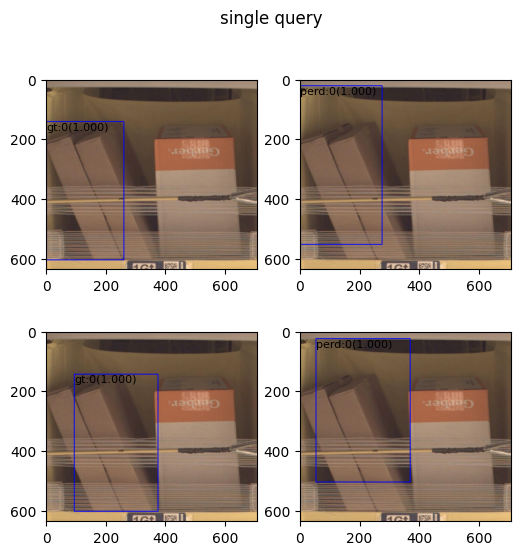

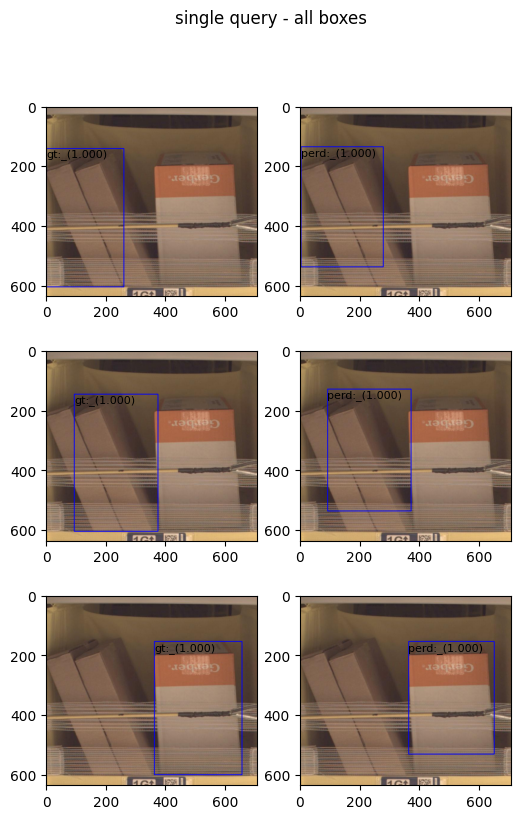

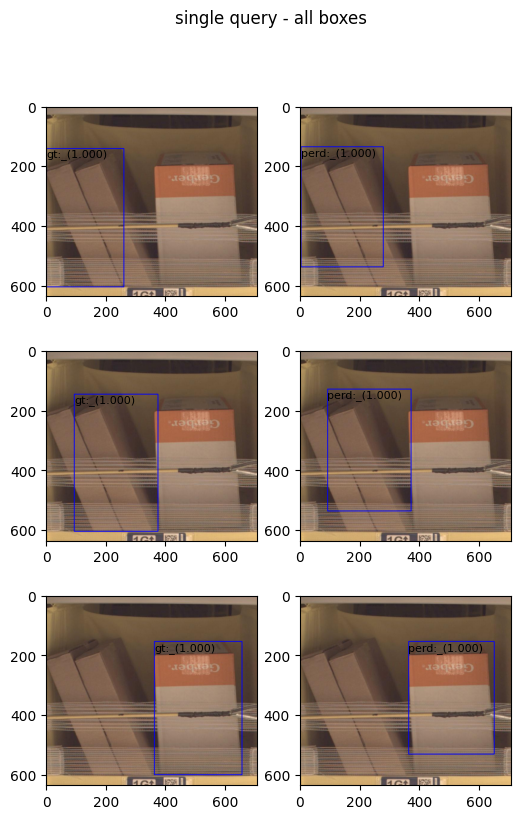

tensor([1.0000, 0.9998], device='mps:0') tensor([[0.2369, 0.4792, 0.3782, 0.9314],
        [0.1953, 0.4331, 0.1792, 0.9332]], device='mps:0') 45


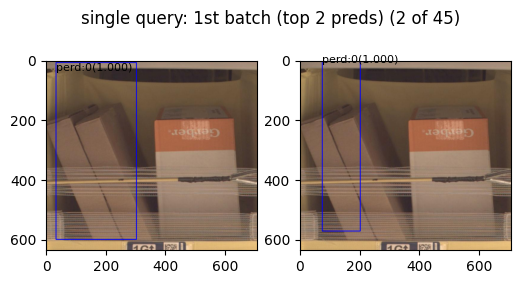

tensor([], device='mps:0') tensor([], device='mps:0', size=(0, 4)) 0


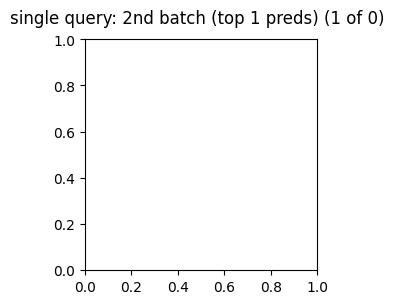

In [46]:
# single query with batch size 2 (2 labels) (2nd batch is no-object)
single_selects1 = get_selects(
    single_pred_logits, single_pred_boxes, 
    single_tgt_labels, single_tgt_qboxes, single_tgt_boxes, loss_fn.matcher)
print(
    "single selects1 (tgt: lbls, bboxes) -> \n   ", 
    [ (single_tgt_labels[i].shape, v.shape) \
        for i, v in enumerate(single_tgt_qboxes) ])
print(
    "single selects1 (pred: lbls, bboxes, probs) -> \n   ",
    [(v.shape, single_selects1[1][i].shape, single_selects1[2][i].shape) \
        for i, v in enumerate(single_selects1[0])])

show_matches(
    sampleimg_pil, 
    single_tgt_labels, single_tgt_qboxes, 
    single_selects1, 'single query')

show_all_box_matches(
    sampleimg_pil, 
    single_tgt_boxes, 
    single_selects1, 'single query - all boxes')

show_topk_preds(
    single_pred_logits[0][:,:1], single_pred_boxes[0], 
    k=2, threshold=0.98,
    title='single query: 1st batch (top 2 preds)')

show_topk_preds(
    single_pred_logits[1][:,:1], single_pred_boxes[1], 
    k=1, threshold=0.98,
    title='single query: 2nd batch (top 1 preds)')

# print_probs(
#     single_pred_logits[1], 
#     (0, 0), 
#     (not_in_query_label, 'no-object'))
# print_probs(
#     single_pred_logits[0], 
#     (2, 0), 
#     (query_label_1, 'no-object'), bin_size=pow(10, -10))

ground-truth label ->  [tensor([1, 1, 1], device='mps:0')]
predicted labels ->  (tensor([[1],
        [1],
        [1]], device='mps:0'),)
predicted probs ->  (tensor([[9.4203e-03, 9.9058e-01],
        [1.9353e-02, 9.8065e-01],
        [2.1379e-04, 9.9979e-01]], device='mps:0',
       grad_fn=<SplitWithSizesBackward0>),)
multi dual selects1 (tgt: lbls, bboxes) -> 
    [(torch.Size([3]), torch.Size([3, 4]))]
multi dual selects1 (pred: lbls, bboxes, probs) -> 
    [(torch.Size([3, 1]), torch.Size([3, 4]), torch.Size([3, 1]))]


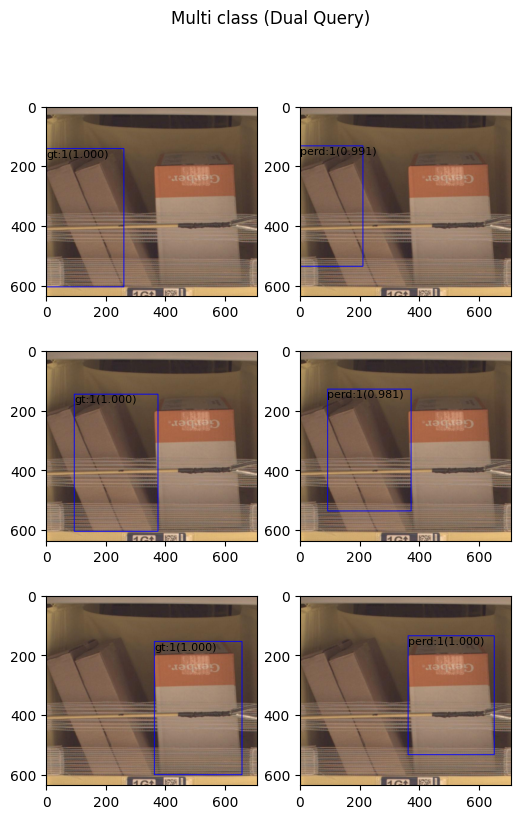

mislabeled. all predictions are labeled as 0
tensor([1.0000, 0.9998, 0.9993], device='mps:0') tensor([[0.2369, 0.4792, 0.3782, 0.9314],
        [0.1953, 0.4331, 0.1792, 0.9332],
        [0.9163, 0.5033, 0.1113, 0.9535]], device='mps:0') 45


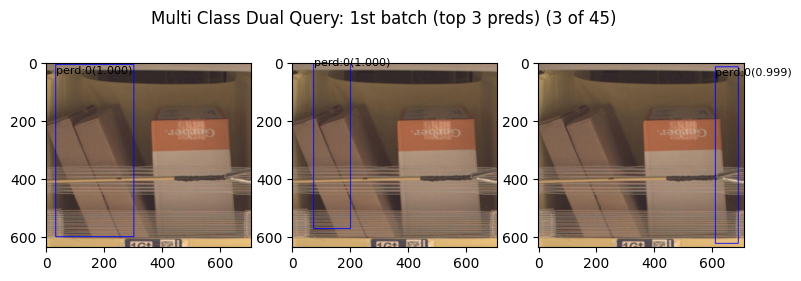

In [38]:
# Dual query (2 labels) with batch size 1

multi_dual_selects1 = get_selects(
    multi_dual_pred_logits, multi_dual_pred_boxes, 
    multi_dual_tgt_labels, multi_dual_tgt_qboxes, loss_fn.matcher)

print(
    "multi dual selects1 (tgt: lbls, bboxes) -> \n   ", 
    [ (multi_dual_tgt_labels[i].shape, v.shape) \
        for i, v in enumerate(multi_dual_tgt_qboxes) ])
print(
    "multi dual selects1 (pred: lbls, bboxes, probs) -> \n   ",
    [ (v.shape, multi_dual_selects1[1][i].shape, multi_dual_selects1[2][i].shape) \
        for i, v in enumerate(multi_dual_selects1[0]) ])

# print_probs(multi_dual_pred_logits[0], (1, 2, 0), (query_label_0, query_label_1, 'no-object'))

show_matches(
    sampleimg_pil, 
    multi_dual_tgt_labels, multi_dual_tgt_qboxes, 
    multi_dual_selects1, 'Multi class (Dual Query)')

print(
    "mislabeled. all predictions are labeled as 0")

show_topk_preds(
    multi_dual_pred_logits[0][:,:1], multi_dual_pred_boxes[0], 
    k=3, threshold=0.98,
    title='Multi Class Dual Query: 1st batch (top 3 preds)')

ground-truth label ->  [tensor([0, 0], device='mps:0'), tensor([1], device='mps:0')]
predicted labels ->  (tensor([[0],
        [0]], device='mps:0'), tensor([[0]], device='mps:0'))
predicted probs ->  (tensor([[1.],
        [1.]], device='mps:0', grad_fn=<SplitWithSizesBackward0>), tensor([[1.]], device='mps:0', grad_fn=<SplitWithSizesBackward0>))
multi dual selects1 (tgt: lbls, bboxes) -> 
    [(torch.Size([2]), torch.Size([2, 4])), (torch.Size([1]), torch.Size([1, 4]))]
multi dual selects1 (pred: lbls, bboxes, probs) -> 
    [(torch.Size([2, 1]), torch.Size([2, 4]), torch.Size([2, 1])), (torch.Size([1, 1]), torch.Size([1, 4]), torch.Size([1, 1]))]


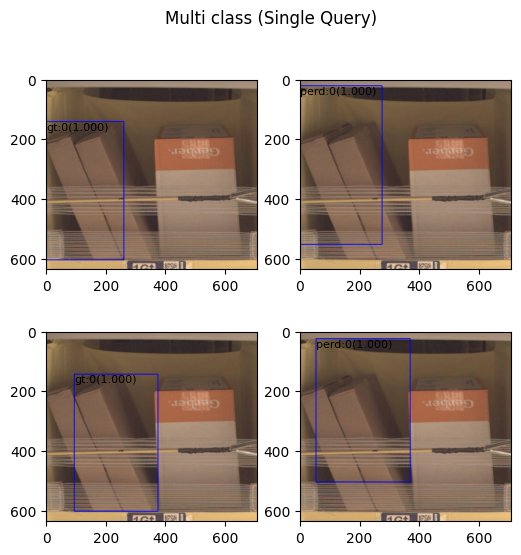

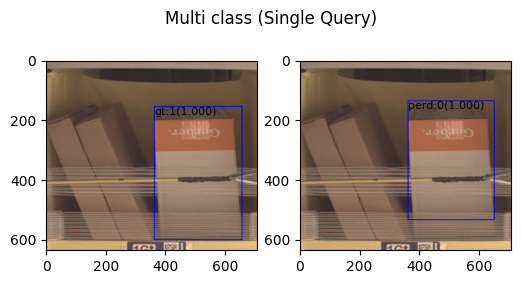

tensor([1.0000, 0.9998, 0.9993], device='mps:0') tensor([[0.2369, 0.4792, 0.3782, 0.9314],
        [0.1953, 0.4331, 0.1792, 0.9332],
        [0.9163, 0.5033, 0.1113, 0.9535]], device='mps:0') 45


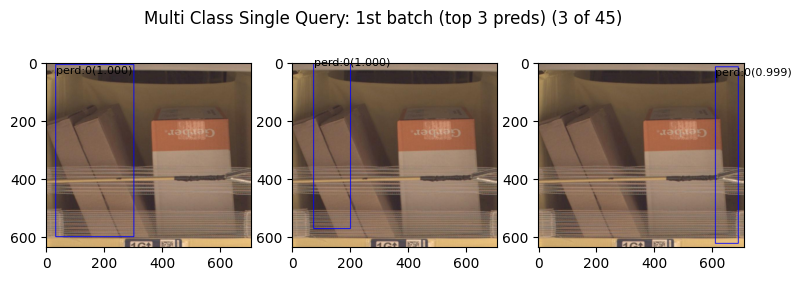

In [39]:
# Single query (2 labels) with batch size 1

multi_single_selects1 = get_selects(
    multi_single_pred_logits, multi_single_pred_boxes, 
    multi_single_tgt_labels, multi_single_tgt_qboxes, loss_fn.matcher)

print(
    "multi dual selects1 (tgt: lbls, bboxes) -> \n   ", 
    [ (multi_single_tgt_labels[i].shape, v.shape) \
        for i, v in enumerate(multi_single_tgt_qboxes) ])
print(
    "multi dual selects1 (pred: lbls, bboxes, probs) -> \n   ",
    [ (v.shape, multi_single_selects1[1][i].shape, multi_single_selects1[2][i].shape) \
        for i, v in enumerate(multi_single_selects1[0]) ])

show_matches(
    sampleimg_pil, 
    multi_single_tgt_labels, multi_single_tgt_qboxes, 
    multi_single_selects1, 'Multi class (Single Query)')

show_topk_preds(
    multi_single_pred_logits[0][:,:1], multi_single_pred_boxes[0], 
    k=3, threshold=0.98,
    title='Multi Class Single Query: 1st batch (top 3 preds)')